In [1]:
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import sqlite3
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from collections import defaultdict
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

from xgboost import XGBRegressor

In [2]:
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        output = frac_str[:-1]
        
        if output=='+':
            return 0.5
        elif output=='-':
            return -0.5
        
        if output[0]=='-':
            output = float(output) - 0.5
        elif output[0]=='+':
            output = float(output) + 0.5
        return output

In [3]:
def calc_bet_winning_percentages(df):
    spread_wl_1 = []
    spread_wl_2 = []
    spread_wl_4 = []
    for row in df.iterrows():
        row = row[1]
        if row['SPREADS_PRED'] > row['SPREAD_1']:
            if row['SPREAD'] > row['SPREAD_1']:
                spread_wl_1.append(1)
            elif row['SPREAD'] < row['SPREAD_1']:
                spread_wl_1.append(0)
                
        elif row['SPREADS_PRED'] < row['SPREAD_1']:
            if row['SPREAD'] < row['SPREAD_1']:
                spread_wl_1.append(1)
            elif row['SPREAD'] > row['SPREAD_1']:
                spread_wl_1.append(0)
                
        if row['SPREADS_PRED'] > row['SPREAD_2']:
            if row['SPREAD'] > row['SPREAD_2']:
                spread_wl_2.append(1)
            elif row['SPREAD'] < row['SPREAD_2']:
                spread_wl_2.append(0)
                
        elif row['SPREADS_PRED'] < row['SPREAD_2']:
            if row['SPREAD'] < row['SPREAD_2']:
                spread_wl_2.append(1)
            elif row['SPREAD'] > row['SPREAD_2']:
                spread_wl_2.append(0)
                
        if row['SPREADS_PRED'] > row['SPREAD_4']:
            if row['SPREAD'] > row['SPREAD_4']:
                spread_wl_4.append(1)
            elif row['SPREAD'] < row['SPREAD_4']:
                spread_wl_4.append(0)
                
        elif row['SPREADS_PRED'] < row['SPREAD_4']:
            if row['SPREAD'] < row['SPREAD_4']:
                spread_wl_4.append(1)
            elif row['SPREAD'] > row['SPREAD_4']:
                spread_wl_4.append(0)  
                
    spread_1_winning_percentage = sum(spread_wl_1) / len(spread_wl_1)
    spread_2_winning_percentage = sum(spread_wl_2) / len(spread_wl_2)
    spread_4_winning_percentage = sum(spread_wl_4) / len(spread_wl_4)
    
    return spread_1_winning_percentage, spread_2_winning_percentage, spread_4_winning_percentage


In [4]:
def eval_model(model, X_train, y_train, X_test, X_test_game_ids):
    #create df of actual spreads, predicted spreads, and betting spreads
    model = model.fit(X_train, y_train)
    
    predicts_df = pd.DataFrame({'SPREADS_PRED': model.predict(X_test)})
    predicts_df['GAME_ID'] = X_test_game_ids
    
    spread_eval_df = test_spreads_df.merge(predicts_df, how='inner', on='GAME_ID')
    spread_eval_df = spread_eval_df.merge(spreads_df, how='inner', on=['HOME_TEAM','GM_DATE'])
    
    #convert betting spreads to floats
    spread_eval_df['SPREAD_1'] = spread_eval_df['SPREAD_1'].apply(convert_to_float)
    spread_eval_df['SPREAD_2'] = spread_eval_df['SPREAD_2'].apply(convert_to_float)
    spread_eval_df['SPREAD_4'] = spread_eval_df['SPREAD_4'].apply(convert_to_float)
    
    #compute winning percentages for each book
    results1, results2, results4 = calc_bet_winning_percentages(spread_eval_df)
    print('Winning percentage on book 1: ', results1)
    print('Winning percentage on book 2: ', results2)
    print('Winning percentage on book 4: ', results4)

In [5]:
#read in dataset
#df = pd.read_csv('moving_average_df.csv')
df = pd.read_csv('weighted_average_df.csv')


In [6]:
#import betting spreads data
spreads_df = pd.read_csv('spreads_df.csv')
spreads_df.drop(columns=['Unnamed: 0'], inplace=True)

In [7]:
#create test set and create test_spreads_df for model evaluation
test_seasons = ['2021-22', '2020-21', '2019-20', '2018-19', '2017-18']
test_df = df[df['SEASON'].isin(test_seasons)].copy()
test_spreads_df = test_df[['GAME_ID','GAME_DATE','TEAM_ID_HOME','TEAM_CITY_HOME','SPREAD']].copy()
test_spreads_df['TEAM_CITY_HOME'] = test_spreads_df['TEAM_CITY_HOME'].map({'LA':'L.A. Clippers', 
                                                                           'Los Angeles':'L.A. Lakers',
                                                                           'Boston': 'Boston',
                                                                           'Golden State': 'Golden State',
                                                                           'Miami': 'Miami',
                                                                           'Dallas':'Dallas',
                                                                           'Phoenix':'Phoenix',
                                                                           'Milwaukee':'Milwaukee',
                                                                           'Philadelphia':'Philadelphia',
                                                                           'Memphis':'Memphis',
                                                                           'Minnesota':'Minnesota',
                                                                           'Utah':'Utah',
                                                                           'New Orleans':'New Orleans',
                                                                           'Toronto':'Toronto',
                                                                           'Brooklyn':'Brooklyn',
                                                                           'Atlanta':'Atlanta',
                                                                           'Denver':'Denver',
                                                                           'Chicago':'Chicago',
                                                                           'Houston':'Houston',
                                                                           'Portland':'Portland',
                                                                           'Cleveland':'Cleveland',
                                                                           'Charlotte':'Charlotte',
                                                                           'Orlando':'Orlando',
                                                                           'New York':'New York',
                                                                           'San Antonio':'San Antonio',
                                                                           'Washington':'Washington',
                                                                           'Detroit':'Detroit',
                                                                           'Sacramento':'Sacramento',
                                                                           'Oklahoma City':'Oklahoma City',
                                                                           'Indiana':'Indiana'
                                                                          })
test_spreads_df.rename(columns={'TEAM_CITY_HOME':'HOME_TEAM', 'GAME_DATE':'GM_DATE'}, inplace=True)
test_spreads_df.head()

,GAME_ID,GM_DATE,TEAM_ID_HOME,HOME_TEAM,SPREAD
0,42100404,2022-06-10,1610612738,Boston,-10
1,42100403,2022-06-08,1610612738,Boston,16
2,42100402,2022-06-05,1610612744,Golden State,19
3,42100401,2022-06-02,1610612744,Golden State,-12
4,42100307,2022-05-29,1610612748,Miami,-4


In [8]:
#create training dataset
train_df = df[df['SEASON'].isin(test_seasons)==False].copy()

In [9]:
#drop unnecessary columns
test_df.drop(columns=['Unnamed: 0',
                 'TEAM_ID_HOME',
                 'GAME_ID',
                 'GAME_DATE',
                 'TEAM_CITY_HOME',
                 'TEAM_ID_AWAY',
                 'TEAM_CITY_AWAY'], inplace=True)
train_df.drop(columns=['Unnamed: 0',
                 'TEAM_ID_HOME',
                 'GAME_ID',
                 'GAME_DATE',
                 'TEAM_CITY_HOME',
                 'TEAM_ID_AWAY',
                 'TEAM_CITY_AWAY'], inplace=True)

In [10]:
#separate spread actuals from training and testing data
X_train = train_df.drop(columns=['SPREAD','SEASON'])
y_train = train_df['SPREAD']
X_test = test_df.drop(columns=['SPREAD', 'SEASON'])
y_test = test_df['SPREAD']

In [11]:
X_train.head()

,WL_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,FT_PCT_HOME,...,TM_TOV_PCT_AWAY,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY
6246,0.894737,42.950000,87.255263,0.493478,12.642105,32.896053,0.385546,19.800000,24.517105,0.811811,...,13.590132,0.573943,0.610817,1.0,0.198570,99.270645,97.120000,80.932842,97.773684,0.532042
6247,0.605263,40.094737,83.347368,0.483280,13.590789,34.535526,0.396074,19.843421,25.225000,0.791893,...,13.867237,0.571075,0.608909,1.0,0.199392,102.943816,101.194079,84.328895,101.361842,0.597051
6248,0.661842,40.169737,83.039474,0.485889,13.652632,33.848684,0.403314,19.667105,25.052632,0.791649,...,13.553553,0.572592,0.609270,1.0,0.199238,103.009526,101.416447,84.514053,101.619737,0.599642
6249,0.961842,43.497368,87.589474,0.498246,12.131579,31.531579,0.385257,18.611842,23.351316,0.798607,...,14.240658,0.576838,0.614697,1.0,0.198511,98.077934,96.179026,80.148382,97.025000,0.543797
6250,0.959211,43.368421,86.096053,0.504111,12.161842,31.277632,0.389743,19.003947,23.602632,0.812183,...,13.805526,0.589704,0.625825,1.0,0.198121,97.593421,95.663184,79.718711,97.113158,0.558429


In [12]:
#Random Forrest implementation
#Baseline RF CV results
rf = RandomForestRegressor()
rf_baseline_score = cross_val_score(rf, X_train, y_train, cv=5)
print('Random Forest baseline CV scores: ', rf_baseline_score)
print('Random Forest baseline avg. CV score: ', rf_baseline_score.mean())

Random Forest baseline CV scores:  [0.12604737 0.14241865 0.15393798 0.09597893 0.10298059]
Random Forest baseline avg. CV score:  0.12427270369421706


In [13]:
#evaluate baseline random forest betting results
rf = RandomForestRegressor()
test_game_ids = test_spreads_df['GAME_ID']
eval_model(rf, X_train, y_train, X_test, test_game_ids)

Winning percentage on book 1:  0.49699054170249357
Winning percentage on book 2:  0.5390549662487946
Winning percentage on book 4:  0.5121951219512195


In [14]:
#Data prep for polynomial regression
df.drop(columns=['Unnamed: 0',
                 'TEAM_ID_HOME',
                 'GAME_DATE',
                 'TEAM_CITY_HOME',
                 'TEAM_ID_AWAY',
                 'TEAM_CITY_AWAY',
                 'SEASON'], inplace=True)

non_feature_cols = {'GAME_ID', 'SPREAD'}
feature_cols = set(df.columns) - non_feature_cols

#standardize features
sclr = StandardScaler()
df[list(feature_cols)] = sclr.fit_transform(df[list(feature_cols)])
df.head()

,GAME_ID,WL_HOME,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,...,EFG_PCT_AWAY,TS_PCT_AWAY,USG_PCT_AWAY,E_USG_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY,SPREAD
0,42100404,0.798311,-0.307805,-0.343791,-0.125422,2.083975,1.945471,0.541952,0.362650,-0.049849,...,2.367805,2.114739,0.0,-1.382459,0.804910,0.760143,0.760196,0.610323,0.722010,-10
1,42100403,0.694802,-0.435849,-0.433634,-0.216272,2.092395,1.955136,0.531318,0.425978,-0.058341,...,2.319777,2.079709,0.0,-1.358269,0.858986,0.823699,0.823752,0.681701,1.006542,16
2,42100402,1.182771,1.732487,0.755110,1.891555,2.036559,1.782831,1.072649,-1.008345,-1.100324,...,1.440565,1.743364,0.0,0.351188,0.453412,0.308360,0.308466,0.090235,1.375392,19
3,42100401,1.545051,1.819497,0.677796,2.125809,1.920897,1.685347,1.062182,-0.897244,-1.000117,...,1.280530,1.602750,0.0,0.453998,0.501871,0.407561,0.407593,0.194118,1.279691,-12
4,42100307,0.680015,0.177178,0.543947,-0.273752,1.269471,1.717842,-0.797425,-0.280073,-0.806921,...,1.497082,1.804023,0.0,0.050824,0.490008,0.405711,0.405825,0.187416,1.365620,-4


Text(0, 0.5, 'cumulative explained variance')

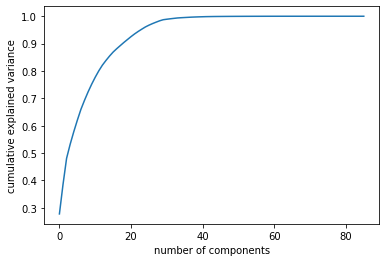

In [15]:
#PCA to minimize multicollinearity
pca = PCA().fit(df[list(feature_cols)])

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

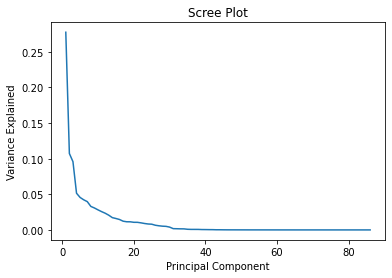

In [16]:
principal_components = np.arange(pca.n_components_)+1
plt.plot(principal_components, pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [17]:
#apply dimensionality reduction to data, keeping n components
n_components = 20
pca=PCA(n_components=n_components)

df_ids_spreads = df[list(non_feature_cols)]

df_pca = pd.DataFrame(pca.fit_transform(df[list(feature_cols)]))
df_pca['GAME_ID'] = df_ids_spreads['GAME_ID']
df_pca['SPREAD'] = df_ids_spreads['SPREAD']
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,GAME_ID,SPREAD
0,7.438530,0.424297,-3.095756,0.036423,-0.958847,-0.664905,1.379690,-2.744205,0.205408,-0.899163,...,-2.369109,-1.027004,1.287674,-1.436776,-0.365350,0.150465,1.989005,0.427870,42100404,-10
1,7.547978,1.345622,-3.327581,0.415138,-0.325071,-0.706003,1.205905,-2.609951,-0.273359,-0.939327,...,-2.582711,-0.970573,1.590805,-1.278673,-0.555998,-0.001635,2.090177,0.497711,42100403,16
2,8.253868,-0.629002,-3.902489,0.298676,0.355438,-0.067882,-1.430732,-2.363971,-0.015611,-0.842605,...,2.938892,1.370164,1.484981,0.737222,-0.416398,1.770788,-0.247418,0.260505,42100402,19
3,8.218027,-1.619046,-4.090230,0.855626,0.302732,-0.005531,-1.284190,-2.385473,-0.330589,-1.157122,...,3.030843,1.409365,1.827634,0.757551,-0.604438,1.836356,-0.264310,0.474179,42100401,-12
4,4.655726,2.525755,-2.418029,-0.826547,0.068223,0.016842,1.173225,-0.345477,1.799596,-1.186388,...,0.979024,-0.172069,0.882947,1.399924,-2.699789,2.248287,-1.474130,-0.238907,42100307,-4


In [18]:
#split pca data into train and test
test_game_ids = set(test_spreads_df['GAME_ID'])

train_pca = df_pca[~df_pca['GAME_ID'].isin(test_game_ids)].copy()
test_pca = df_pca[df_pca['GAME_ID'].isin(test_game_ids)].copy()

train_game_ids = train_pca['GAME_ID'].copy()
test_game_ids = test_pca['GAME_ID'].copy()

y_train_pca = train_pca['SPREAD']
X_train_pca = train_pca.drop(columns=['SPREAD','GAME_ID'])

y_test_pca = test_pca['SPREAD']
X_test_pca = test_pca.drop(columns=['SPREAD','GAME_ID'])

X_train_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
6246,10.545010,-2.664971,-5.664758,0.581225,-0.680653,2.144229,-1.121617,-0.983935,-1.088178,-0.266525,-3.341769,-0.848237,-0.386066,-1.104216,-0.075649,-0.897042,0.450924,-0.177046,0.212854,-0.764657
6247,10.463079,3.941168,-5.939773,1.073141,0.750744,1.218793,1.070123,-1.061594,1.508069,-0.385576,3.255034,-1.226976,0.564883,0.935674,-0.051696,0.532786,0.501349,-0.016323,-0.008416,-1.048185
6248,10.831754,3.699977,-6.669484,1.270346,0.397322,0.877904,1.192575,-0.911929,1.230937,-0.476025,3.276369,-1.136794,0.801415,1.083689,-0.125992,0.282266,0.653905,0.208378,-0.032003,-0.815719
6249,10.478428,-3.149268,-7.340134,1.076279,0.227183,0.797151,-1.216743,-0.905667,-0.410517,-1.294673,-3.788541,-1.192513,-1.136138,-1.662159,-0.211766,0.127815,0.892039,0.132565,0.309868,-0.581482
6250,10.878306,-1.902641,-8.079014,0.734564,-0.475570,1.507463,-1.447235,-1.708021,-0.896984,-1.831495,-3.209210,-0.865821,-1.085628,-1.207876,-0.658774,-0.247286,0.627110,0.076677,0.814285,-0.589096


In [19]:
#polynomial regression using polynomial features of degree 2
degree = 2
poly=PolynomialFeatures(degree)
X_train_poly = poly.fit_transform(X_train_pca)
X_test_poly = poly.fit_transform(X_test_pca)
poly_reg = LinearRegression()

poly_reg_baseline_score = cross_val_score(poly_reg, X_train_poly, y_train_pca, cv=5)
print('Polynomial regression baseline CV scores: ', poly_reg_baseline_score)
print('Polynomial regression baseline avg. CV score: ', poly_reg_baseline_score.mean())

Polynomial regression baseline CV scores:  [0.12806747 0.13791647 0.16013016 0.10198493 0.11259376]
Polynomial regression baseline avg. CV score:  0.12813855702253704


In [20]:
#evaluate baseline polynomical regression model
poly_reg = LinearRegression()
eval_model(poly_reg, X_train_poly, y_train_pca, X_test_poly, test_game_ids)

Winning percentage on book 1:  0.48865589549673427
Winning percentage on book 2:  0.5209638554216868
Winning percentage on book 4:  0.4978973927670311


In [21]:
#xgboost implementation
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
xgb_predicts = xgb.predict(X_test)

print('XGBoost baseline: ', r2_score(y_test, xgb_predicts))

XGBoost baseline:  -0.06341058857225534


In [22]:
eval_model(xgb, X_train, y_train, X_test, test_game_ids)

Winning percentage on book 1:  0.4944998281196287
Winning percentage on book 2:  0.5228915662650603
Winning percentage on book 4:  0.5063078216989066


In [23]:
#Tuned RF
#create hyperparameter grid
'''
rf = RandomForestRegressor()
n_estimators = [int(x) for x inn np.linspace(100, 1000, num=10)]
max_features =['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 50, num=10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 5]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=31, n_jobs=-1)

rf_random.fit(X_train, y_train)
'''

"\nrf = RandomForestRegressor()\nn_estimators = [int(x) for x inn np.linspace(100, 1000, num=10)]\nmax_features =['auto', 'sqrt']\nmax_depth = [int(x) for x in np.linspace(10, 50, num=10)]\nmax_depth.append(None)\nmin_samples_split = [2, 5, 10]\nmin_samples_leaf = [1, 2, 5]\nbootstrap = [True, False]\n\nrandom_grid = {'n_estimators': n_estimators,\n               'max_features': max_features,\n               'max_depth': max_depth,\n               'min_samples_split': min_samples_split,\n               'min_samples_leaf': min_samples_leaf,\n               'bootstrap': bootstrap}\n\nrf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=31, n_jobs=-1)\n\nrf_random.fit(X_train, y_train)\n"